In [3]:
from trad_method import mean_imputation, knn_imputation, bayesian_pca_imputation, interpolation_imputation
from sklearn.model_selection import train_test_split
import random
import os
import sys
import numpy as np
import torch
from process_tool import mask_slices, load_daily_data
sys.path.append(os.path.expanduser('/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/functions'))
from data_processing import process_files, load_daily_data
from datetime import datetime, timedelta
from plotting_code import plot_traditional_imputation_results

# This tool is created for pre-process the data
start_UT = 0
end_UT = 12
dt = 0.1
data_dir = '/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/data'
folder_list = ['.DS_Store', 'Results_2d_ASCII_2020.zip', 'Results_2d_ASCII_2018.zip', 'Results_2d_ASCII_2019.zip', '2017', '2019', '2020', '2018', 'Results_2d_ASCII_2017.zip', '2016', 'Results_2d_ASCII_2016.zip']
desired_folders = [os.path.join(data_dir,folder) for folder in folder_list if folder.isdigit() and 2016 <= int(folder) <= 2018]
print(desired_folders)
# Assuming desired_folders is a list of directories
files = []
for folder in desired_folders:
    files += [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('DTWUV.dat')]

# Add the directory containing the custom module to the Python path
# case = 'KNN Imputation', 'Mean Imputation', 'BPCA Imputation', 'Interpolation Imputation'
# case = 'Interpolation Imputation'
# case = 'KNN Imputation'
case = 'Mean Imputation'
# case = 'BPCA Imputation'
all_imputed_data_dict = {}
all_original_data_dict = {}
all_mask_dict = {}
# Iterate through the files
for filename in files:
    # Load the daily data
    full_mat_np = load_daily_data(filename, start_UT, end_UT)
    alt_lvs = full_mat_np['Altitudes [km]']
    t_stps = full_mat_np['YYYYMMDD_hhmm']
    # Iterate through the keys in the loaded data, excluding specific keys
    for key in full_mat_np.keys():
        if key in ["Na Density (cm^(-3))", "Temperature (K)", "Vertical Wind (m/s)"]:
            # Extract the variable data
            #indices = np.where((full_mat_np['Altitudes [km]'] > 80) & (full_mat_np['Altitudes [km]'] < 100))
            batch_data = full_mat_np[key]#[indices]
            # Expand dimensions if necessary
            if batch_data.ndim == 3:  # Missing input_dim dimension
                data = np.expand_dims(batch_data, axis=-1)  # Add input_dim dimension
            elif batch_data.ndim == 2:  # Missing both batch_size and input_dim
                data = np.expand_dims(batch_data, axis=0)  # Add batch_size dimension
                data = np.expand_dims(data, axis=-1)  # Add input_dim dimension
            else:
                data = batch_data  # Already in correct shape
            # Convert data to PyTorch tensor
            data_tensor = torch.tensor(data, dtype=torch.float32)
            # Apply masking
            masked_data, random_mask = mask_slices(np.transpose(np.squeeze((data_tensor))),missing_ratio=0.5, strip_width=5)
            #masked_data = np.squeeze(masked_data.detach().cpu().numpy())
            #random_mask = np.squeeze(random_mask.detach().cpu().numpy())
            # Perform mean imputation along the specified axis
            if case == 'Mean Imputation':
                imputed_data = mean_imputation(masked_data, 0, random_mask)
            elif case == 'KNN Imputation':
                imputed_data = knn_imputation(masked_data)
            elif case == 'BPCA Imputation':
                imputed_data = bayesian_pca_imputation(masked_data, random_mask)
            elif case == 'Interpolation Imputation':
                imputed_data = interpolation_imputation(masked_data, random_mask, method='linear', axis=0)
            # Stack all data together
            if key not in all_imputed_data_dict:
                all_imputed_data_dict[key] = []
                all_original_data_dict[key] = []
                all_mask_dict[key]=[]
            else:
                all_imputed_data_dict[key].append(imputed_data)
                all_original_data_dict[key].append(np.transpose(np.squeeze(data_tensor.detach().cpu().numpy())))
                all_mask_dict[key].append(random_mask)     
        if key in ['Altitudes [km]','YYYYMMDD_hhmm']:
            if key not in all_original_data_dict:
                all_original_data_dict[key] = []
            else:
                all_original_data_dict[key].append(full_mat_np[key])


['/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/data/2017', '/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/data/2018', '/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/data/2016']


/Users/huj7/MVI-2D-multivariable/Traditional/trad_method.py:24: RuntimeWarning: Mean of empty slice
  mean_values = np.nanmean(data, axis=axis, keepdims=True)


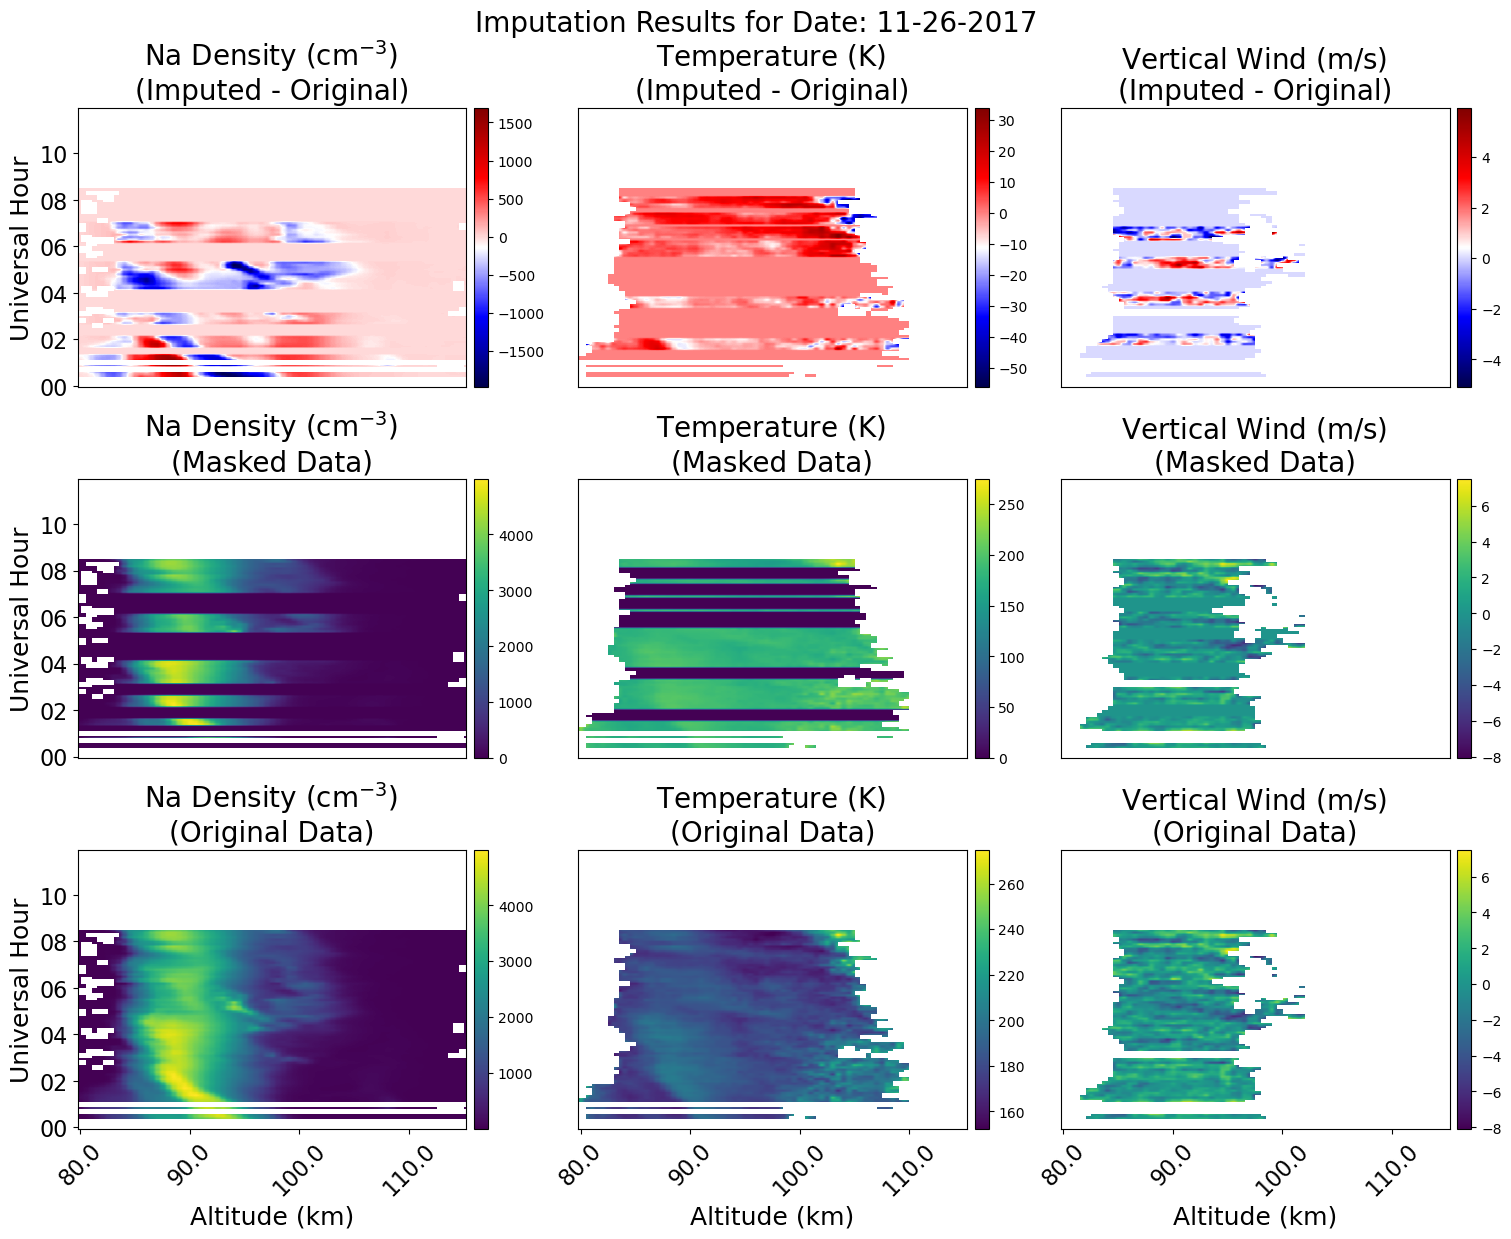

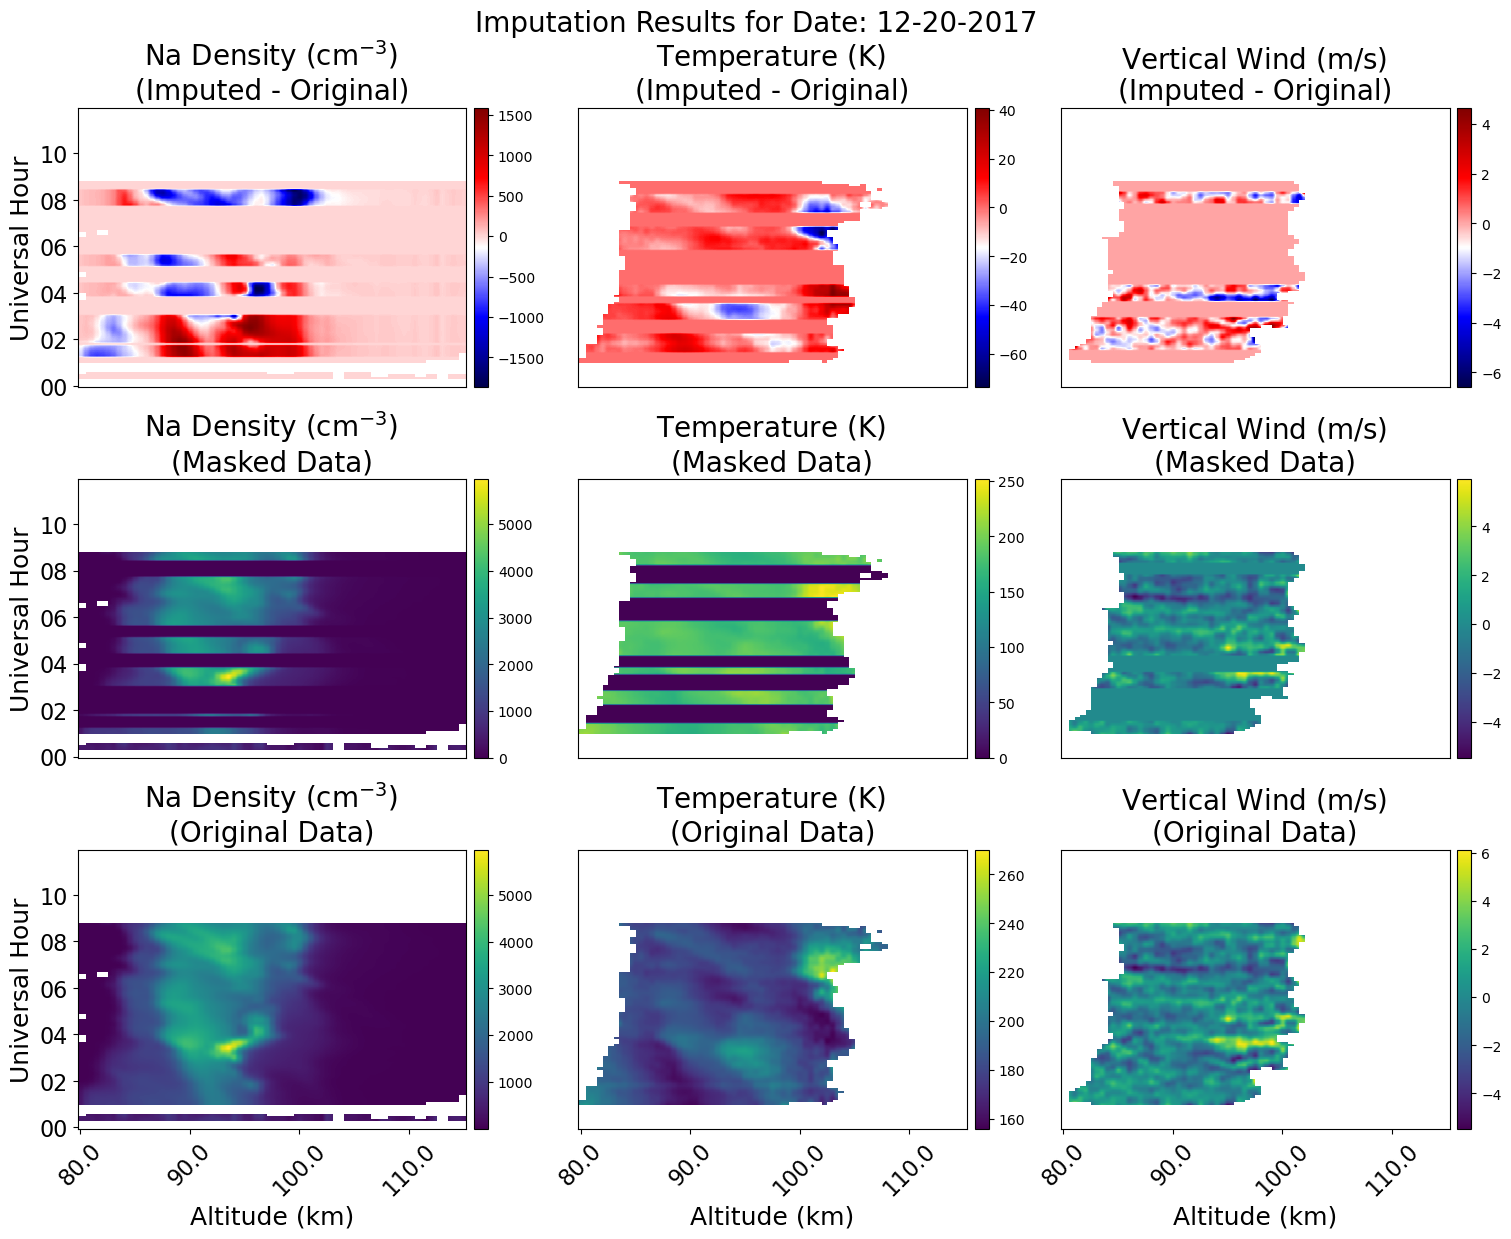

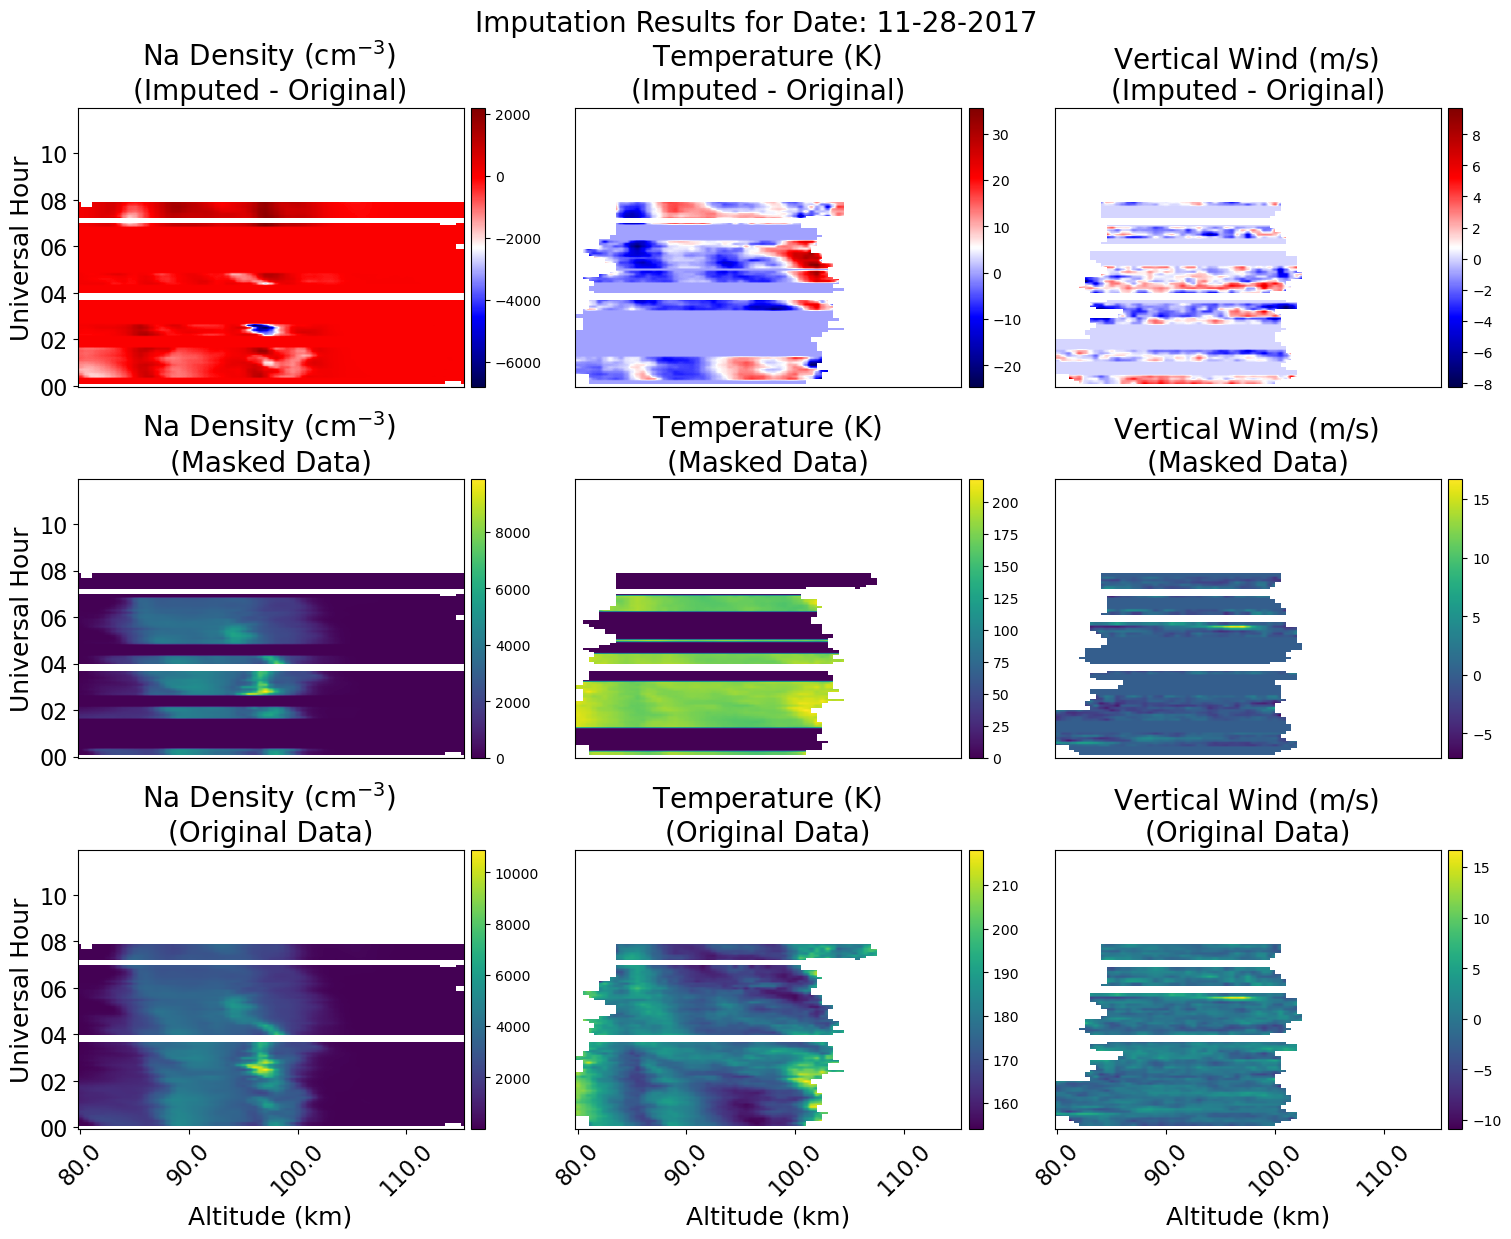

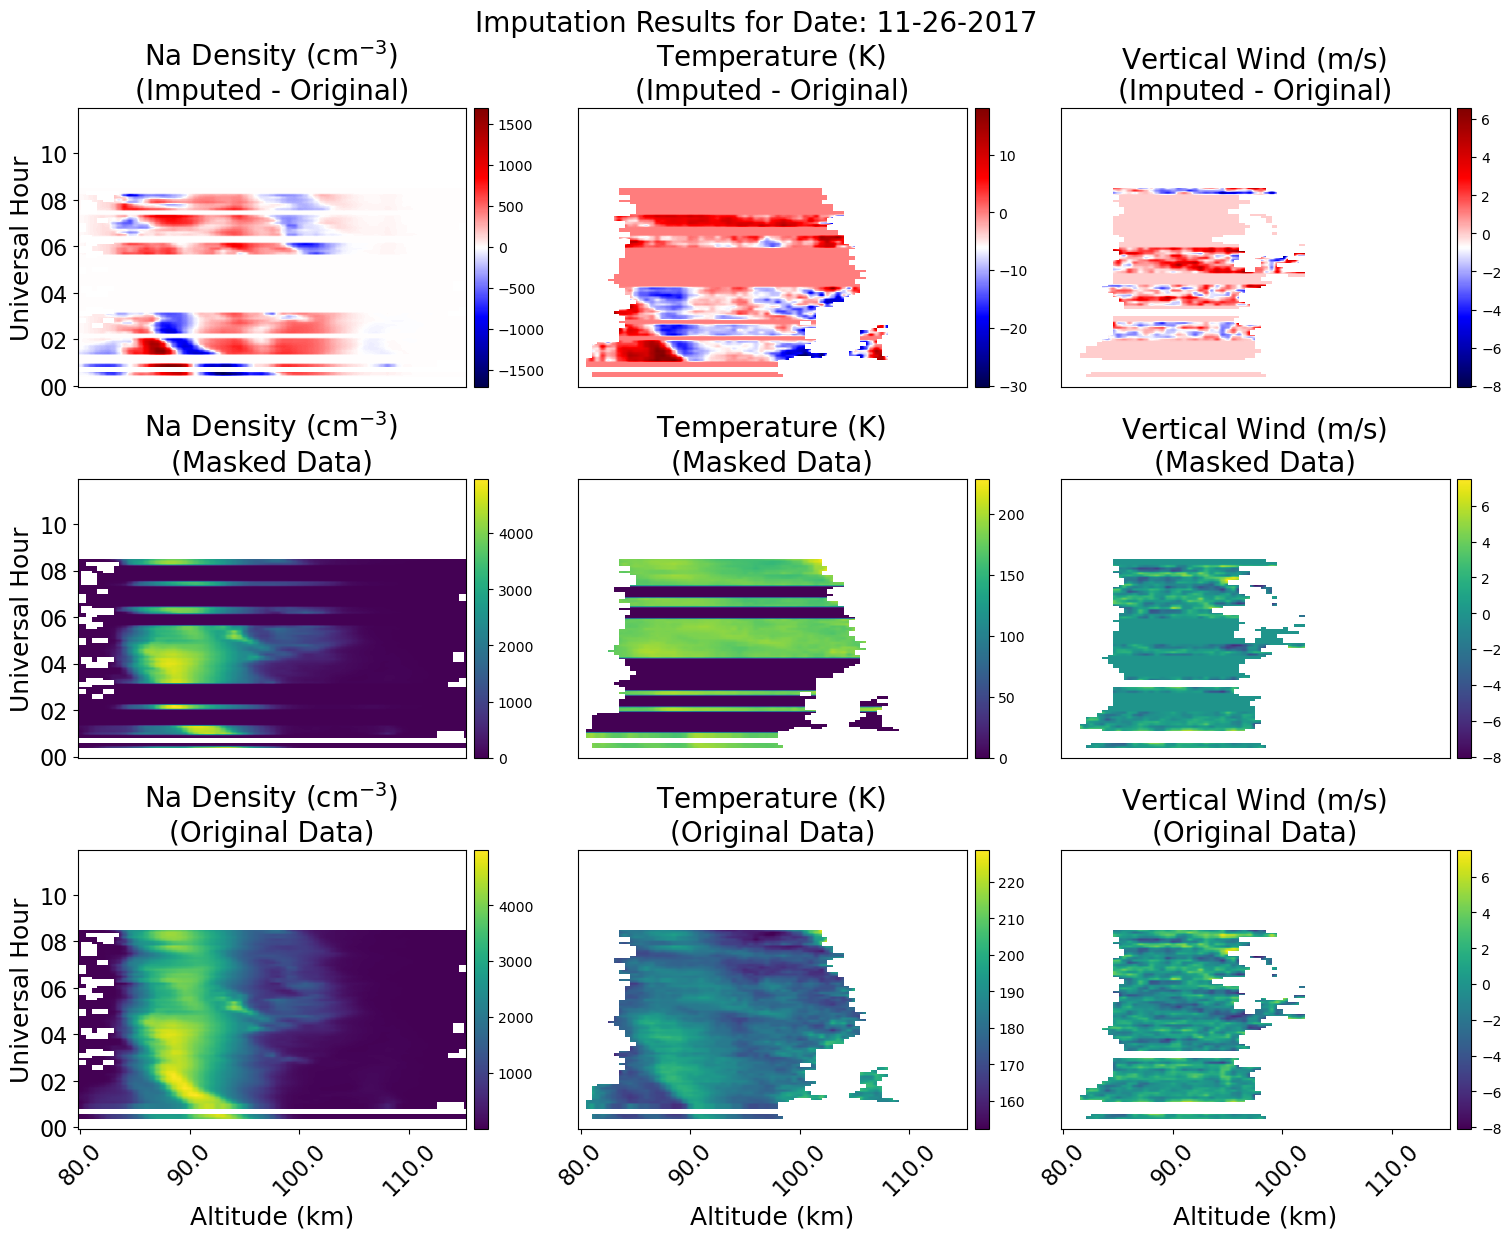

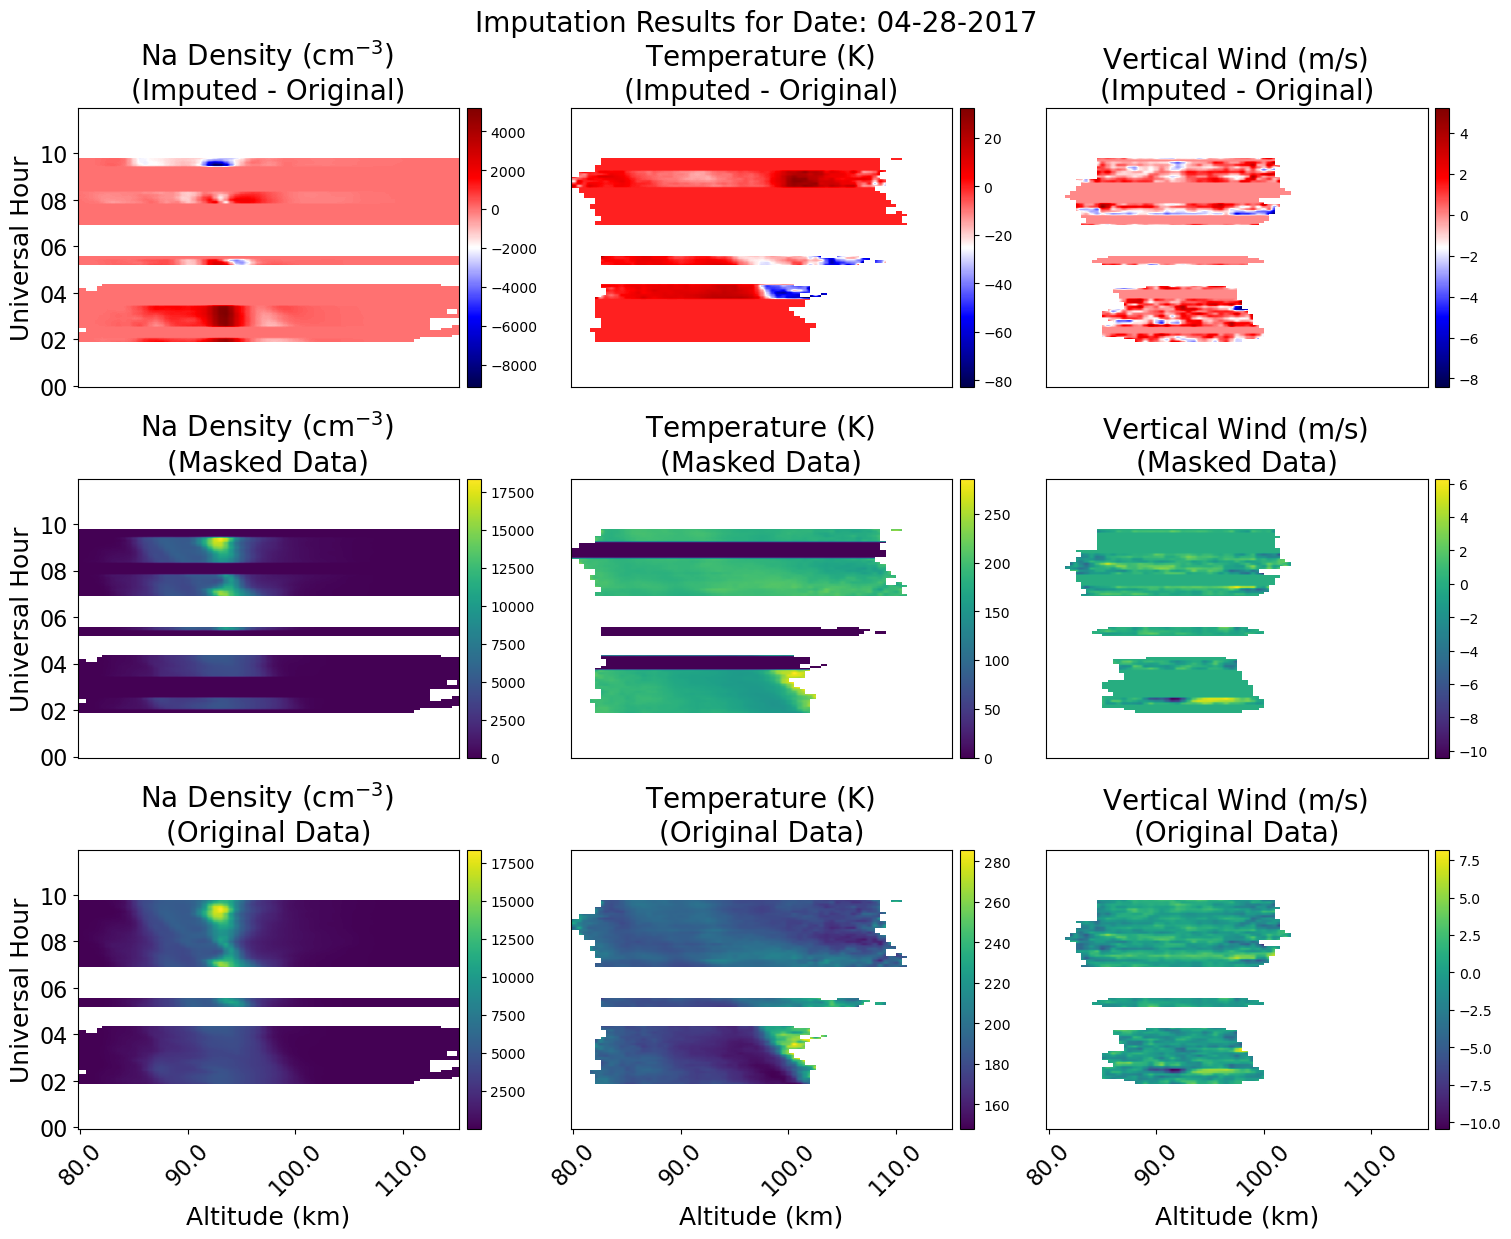

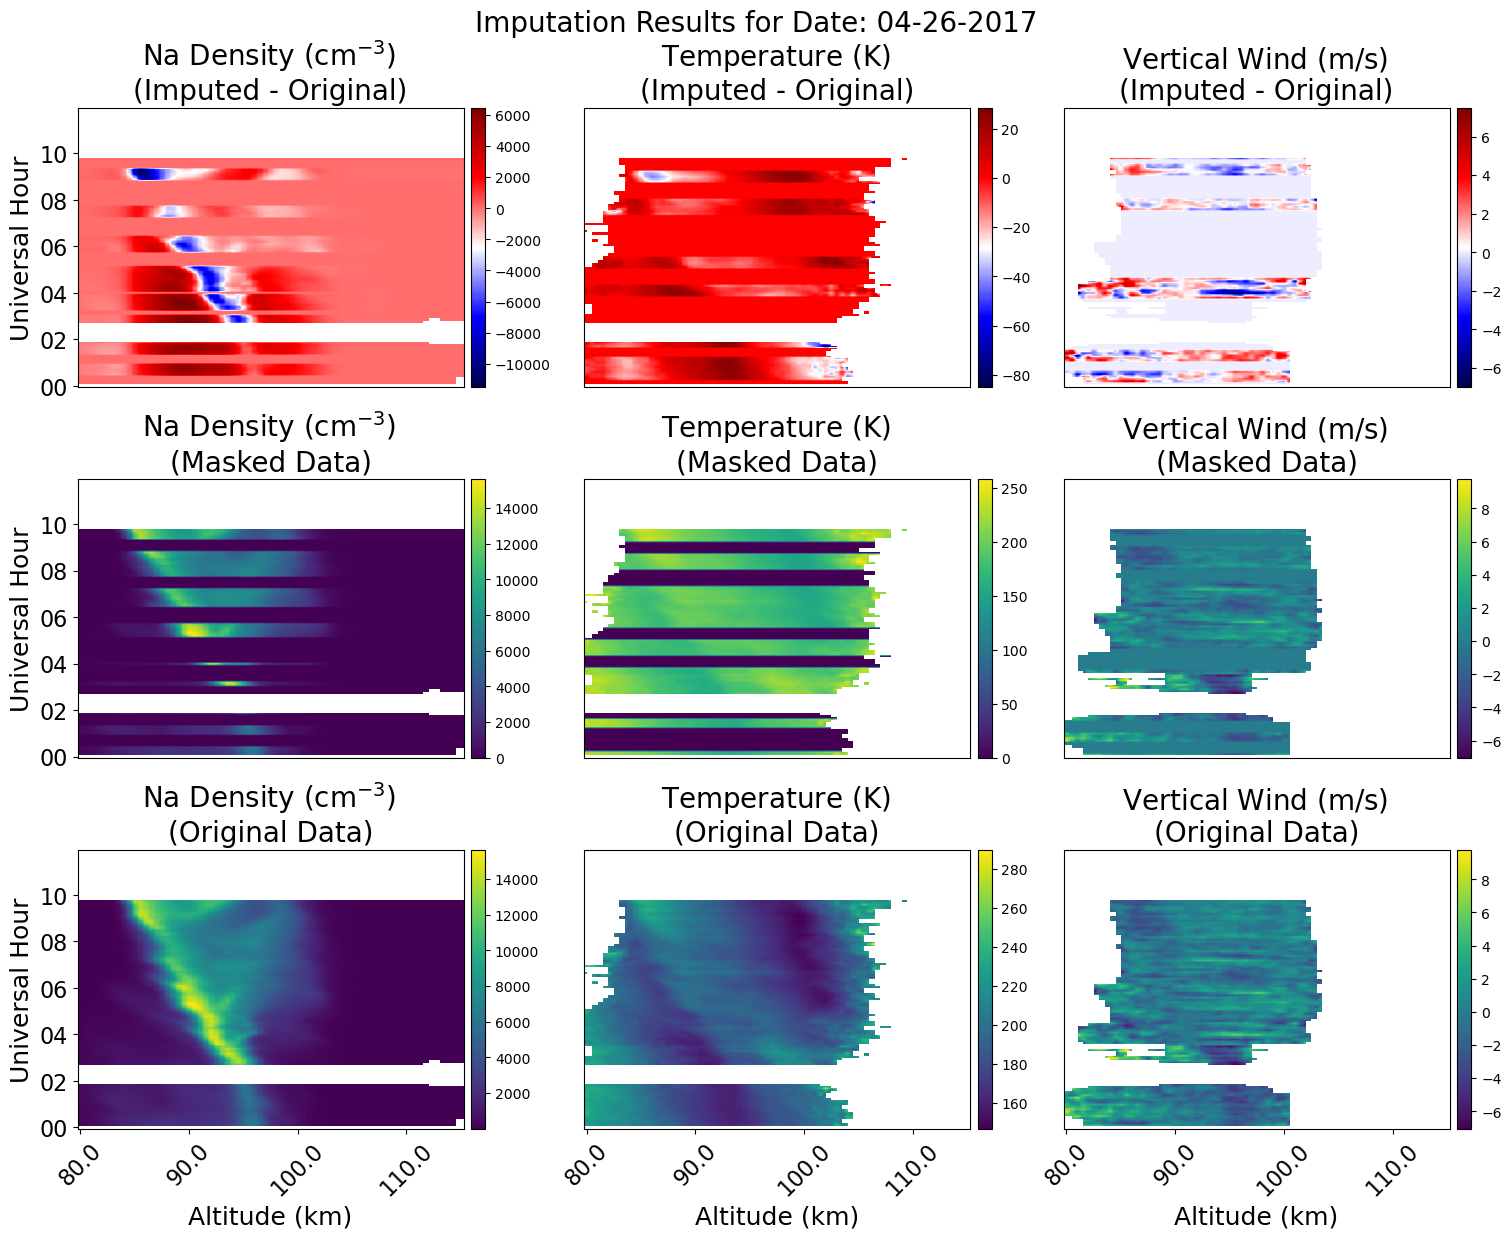

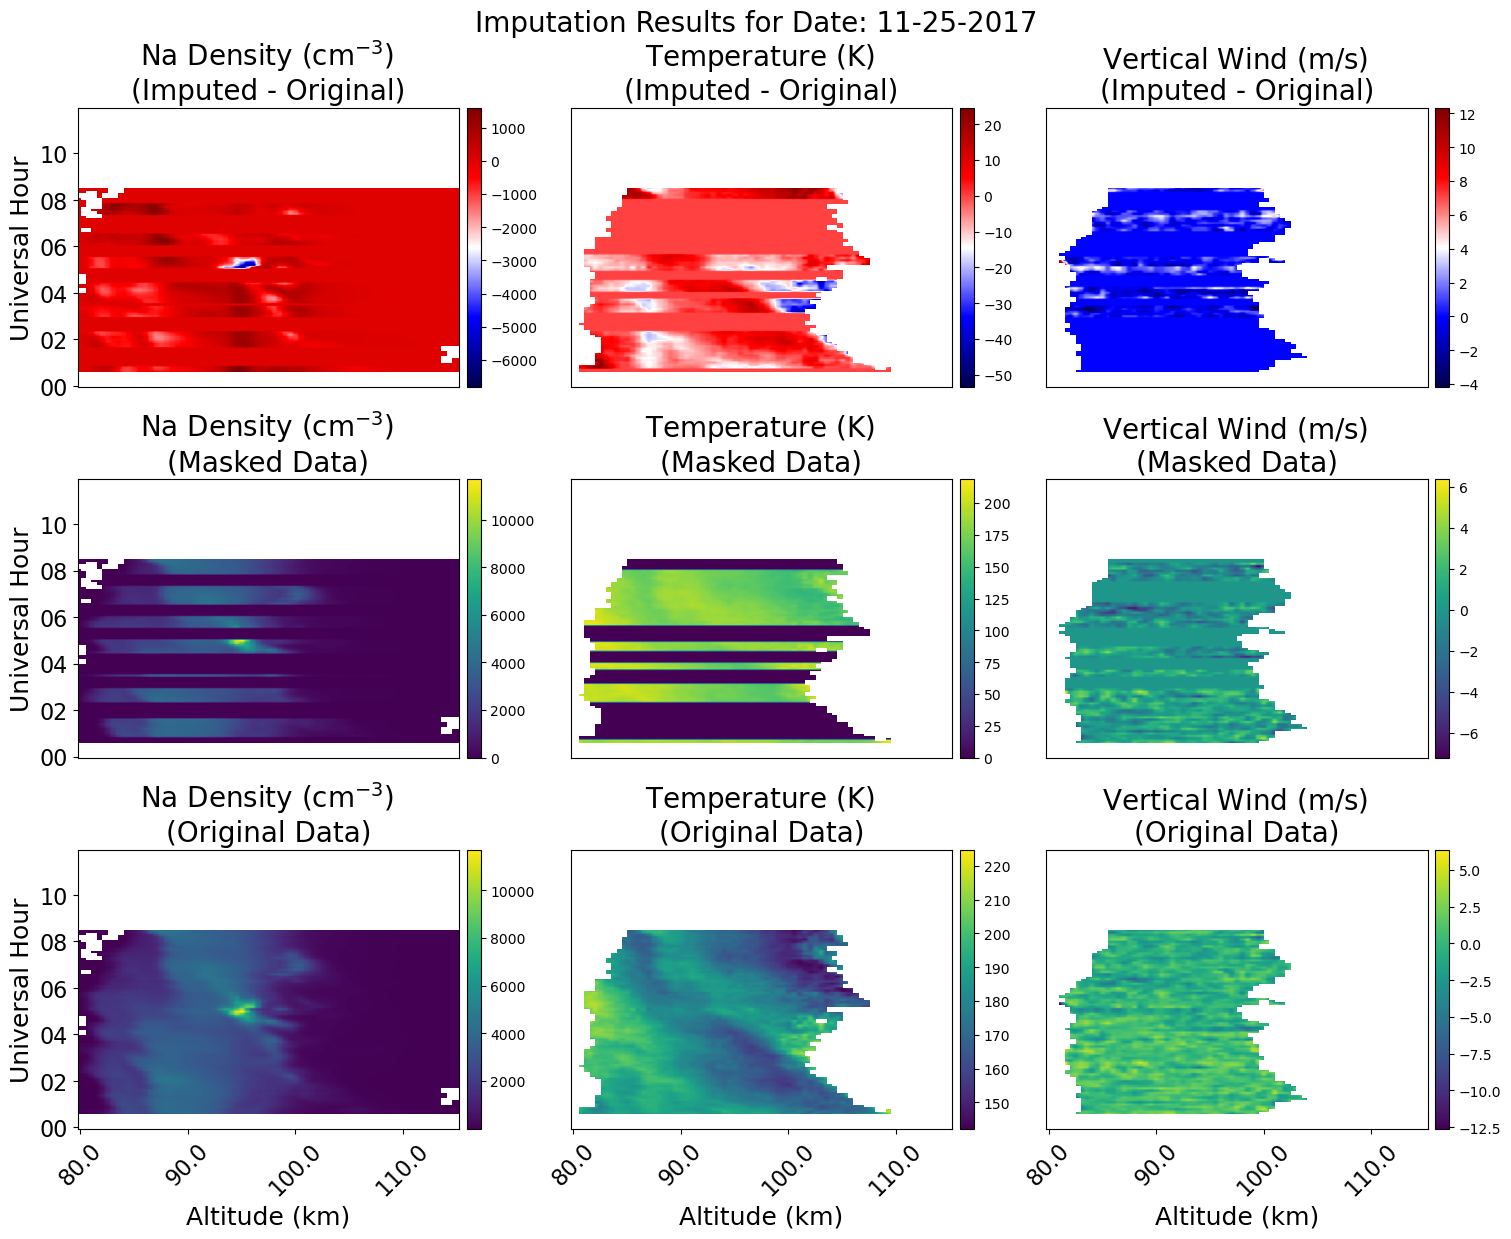

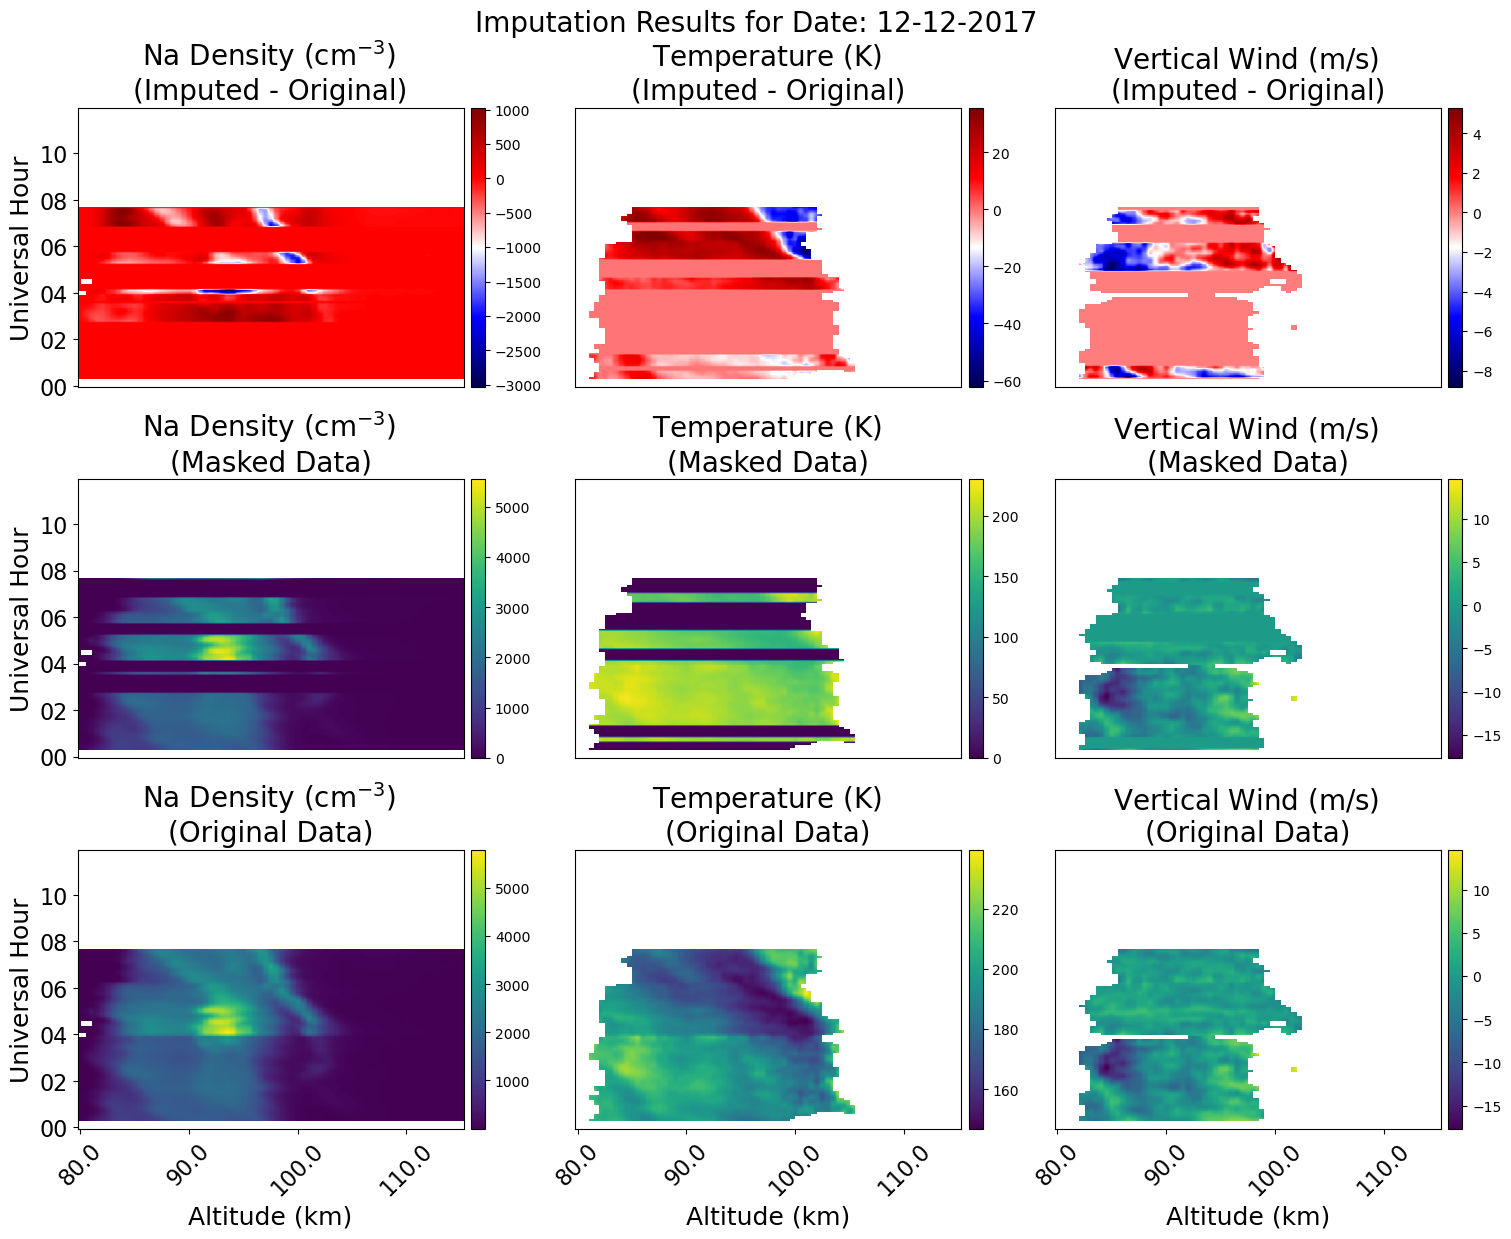

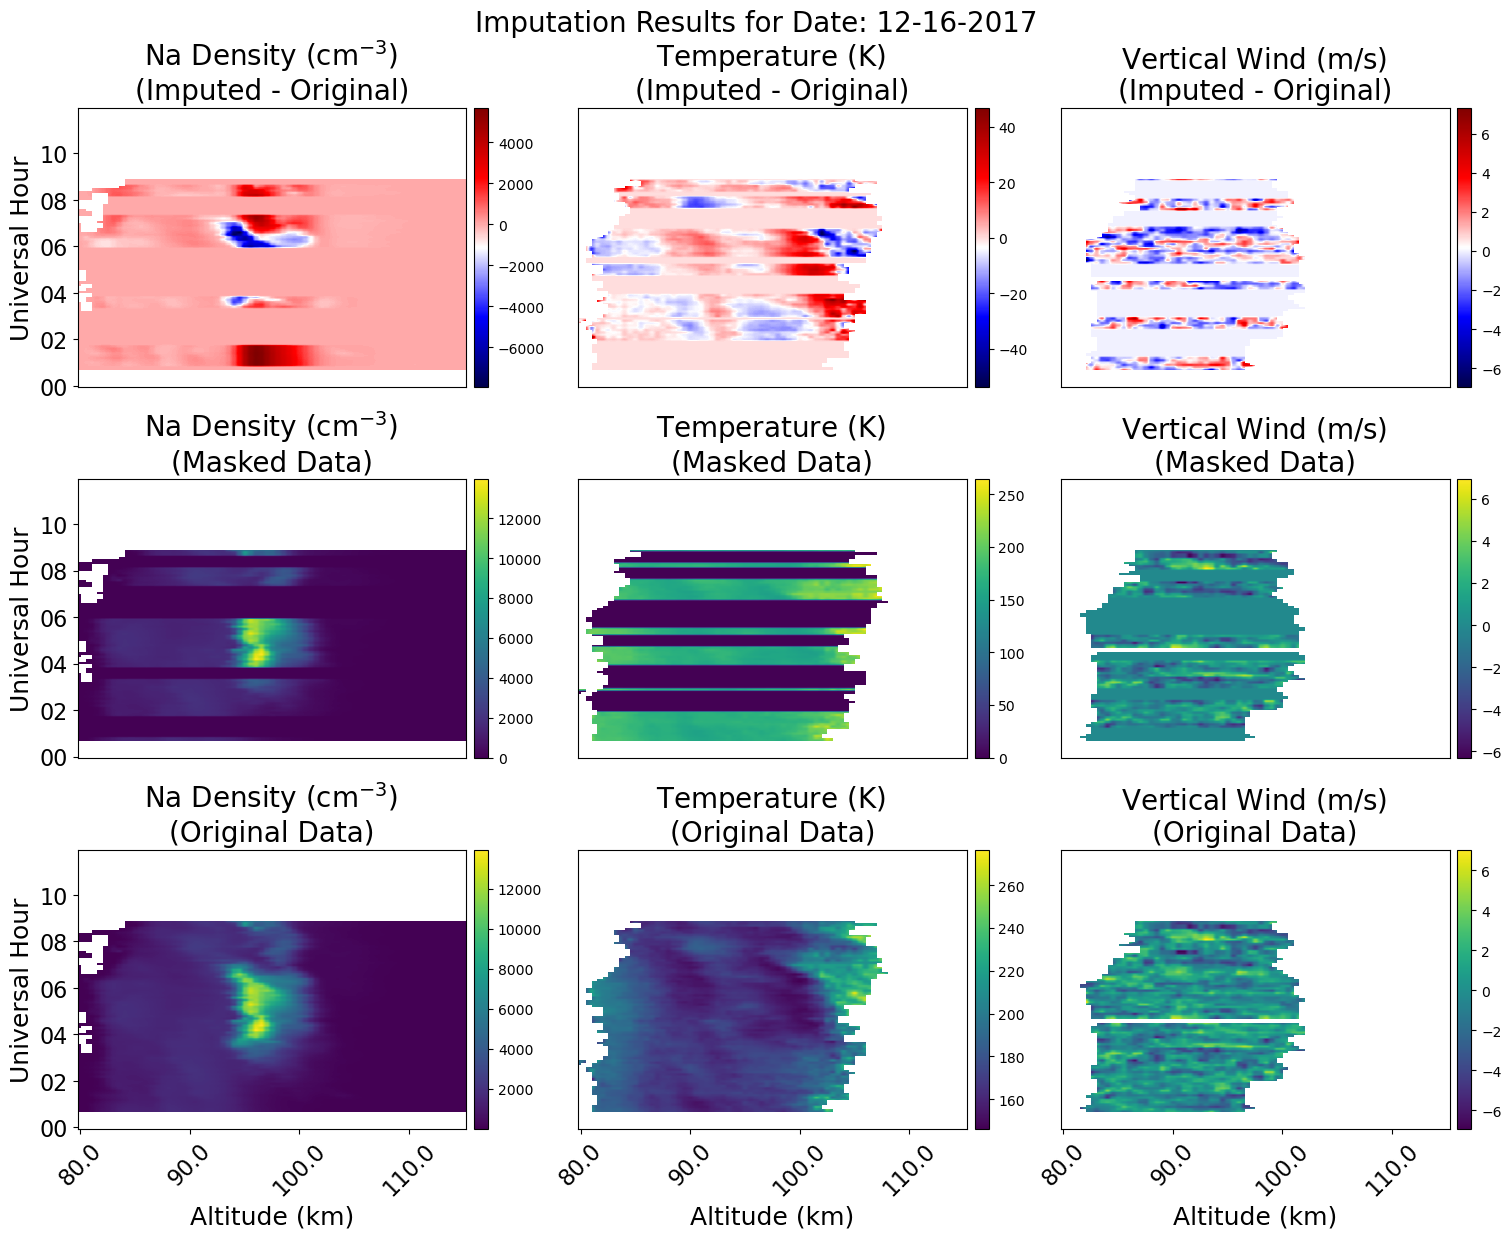

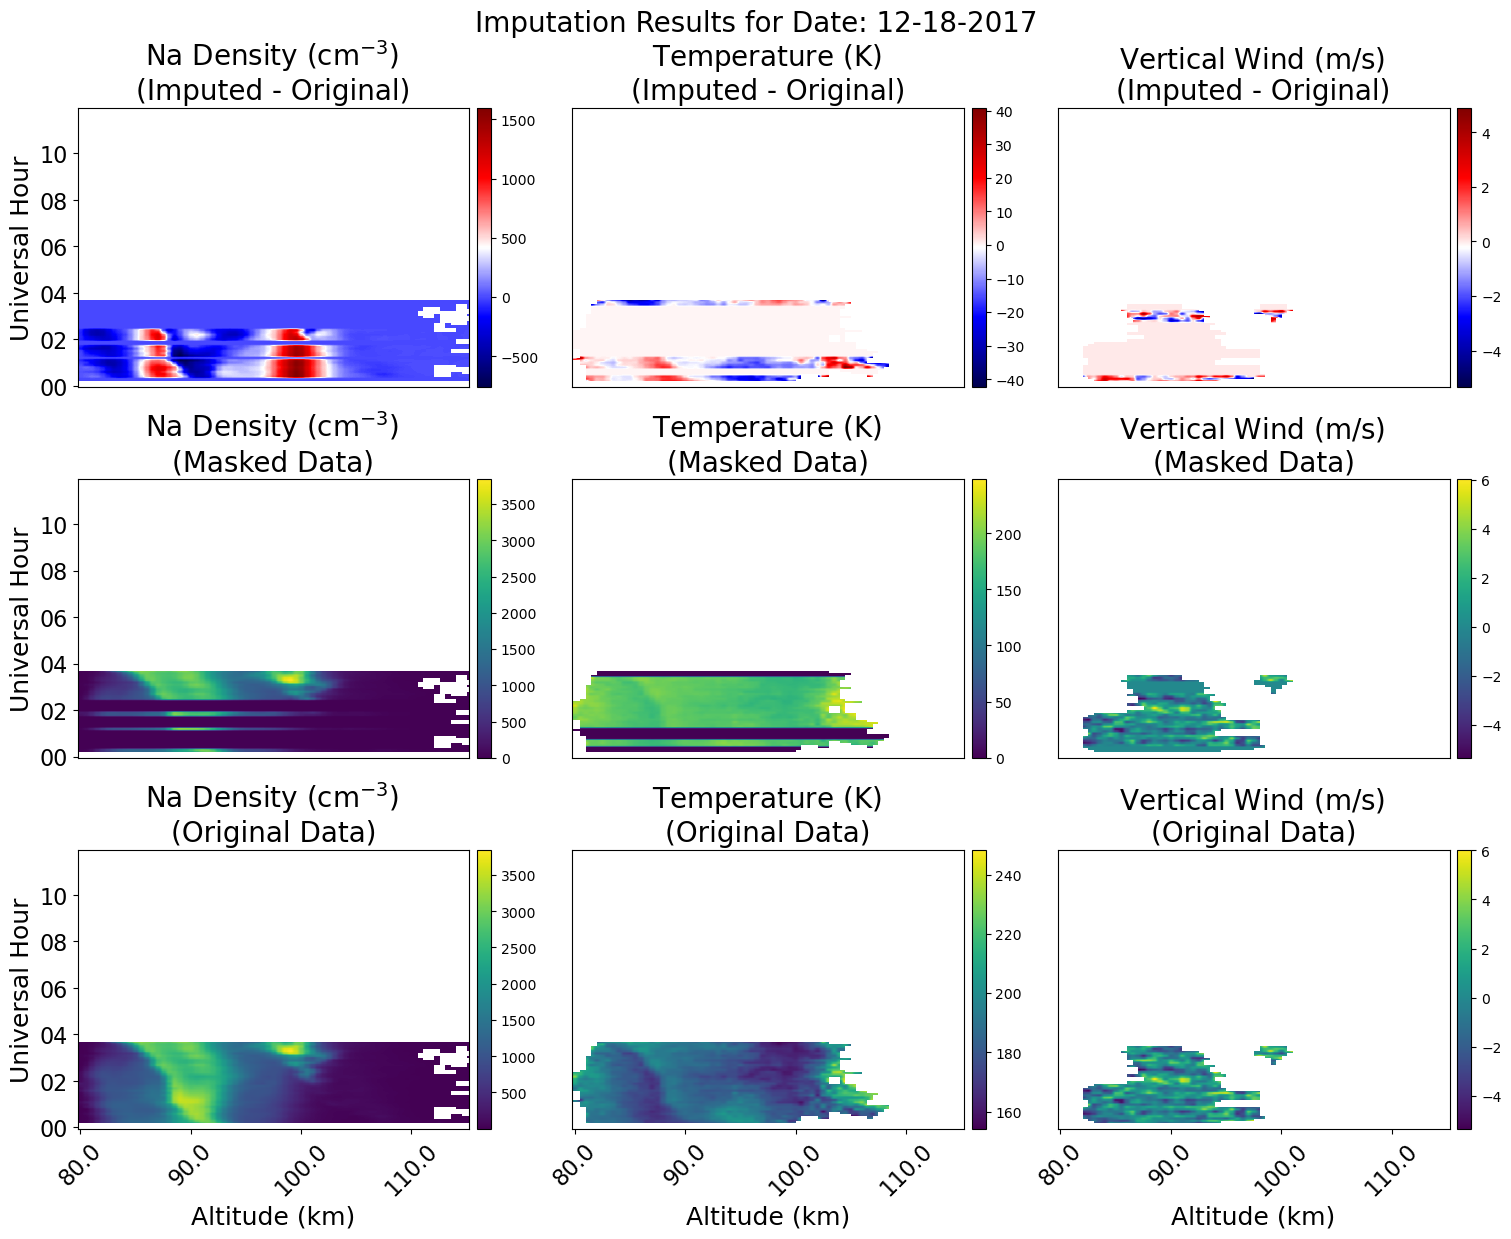

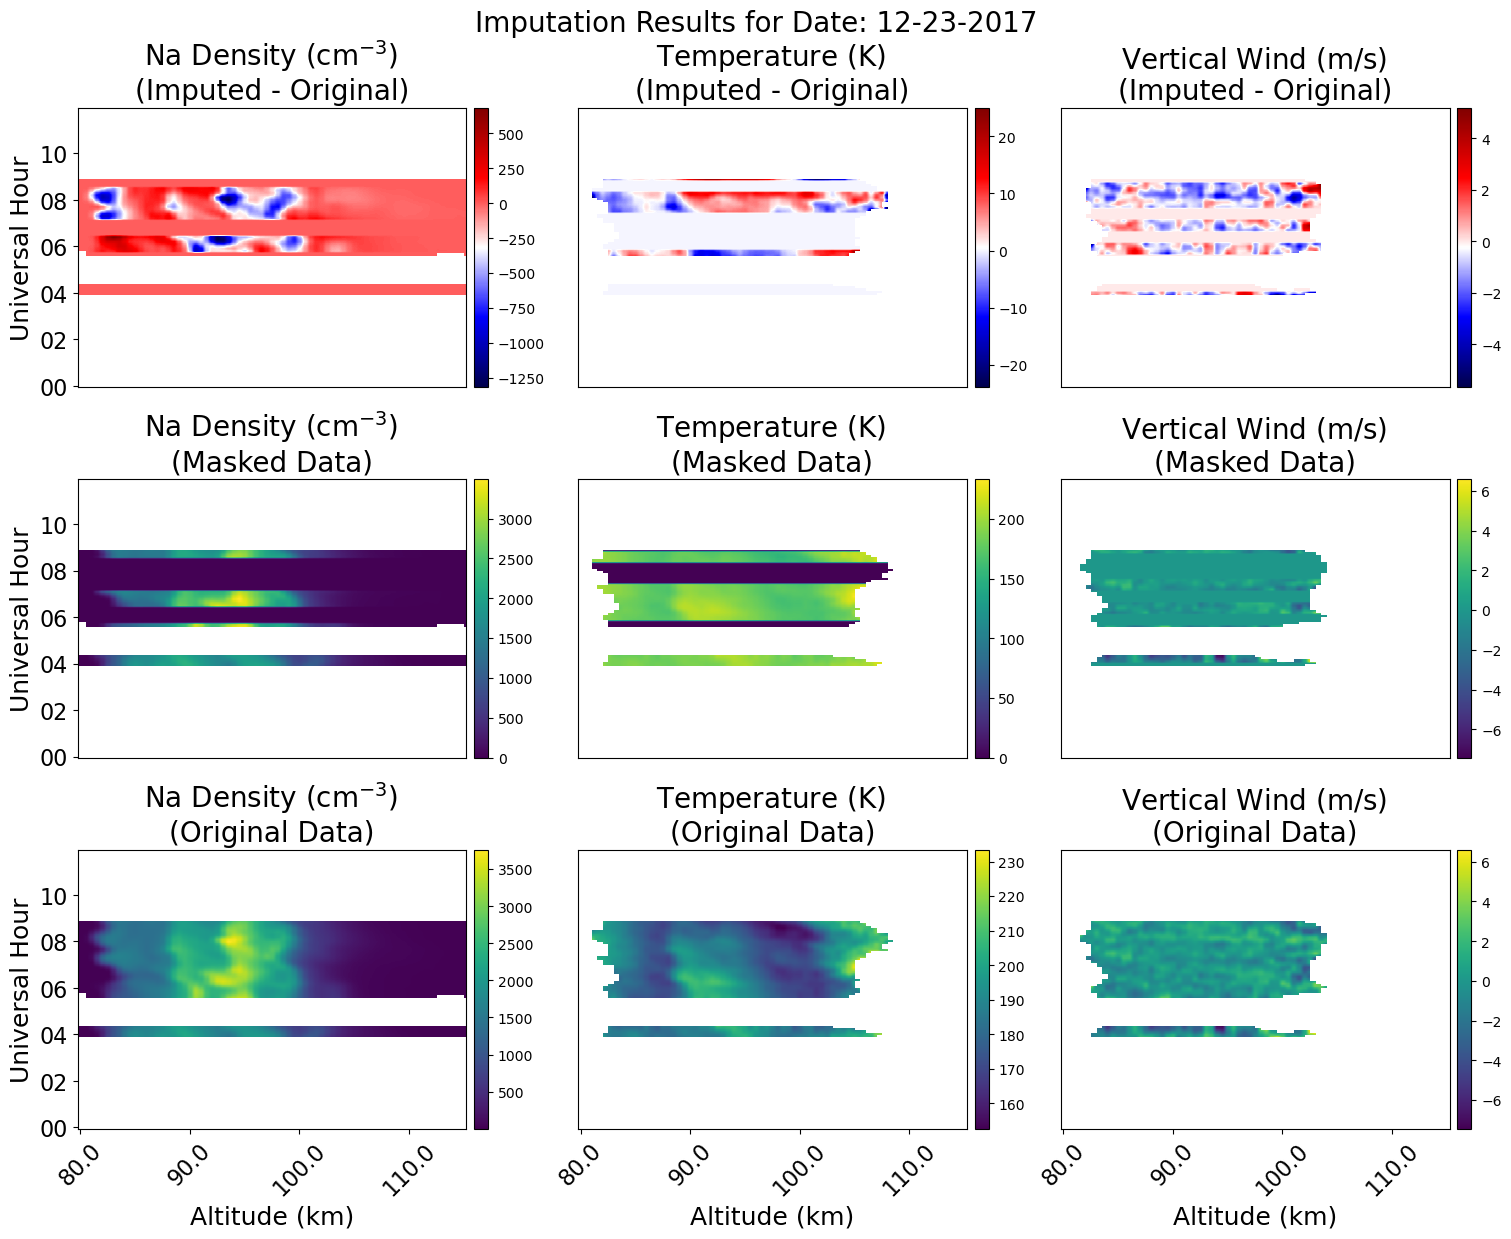

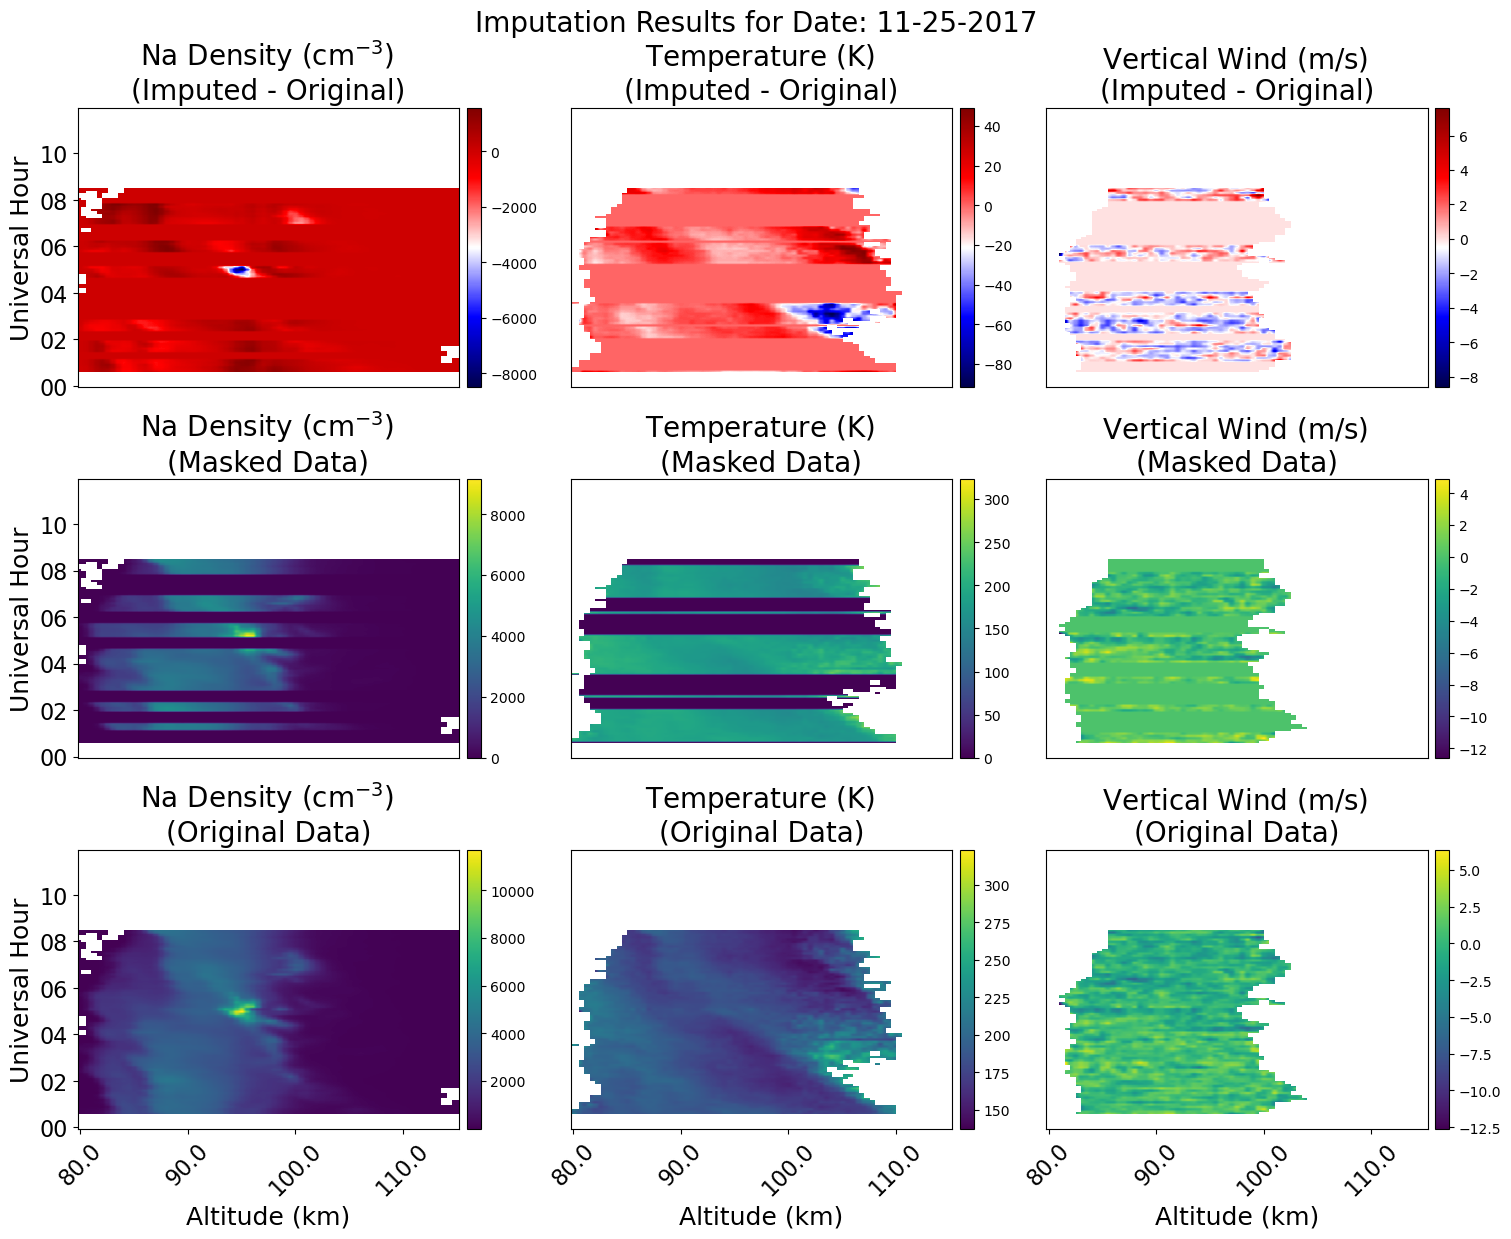

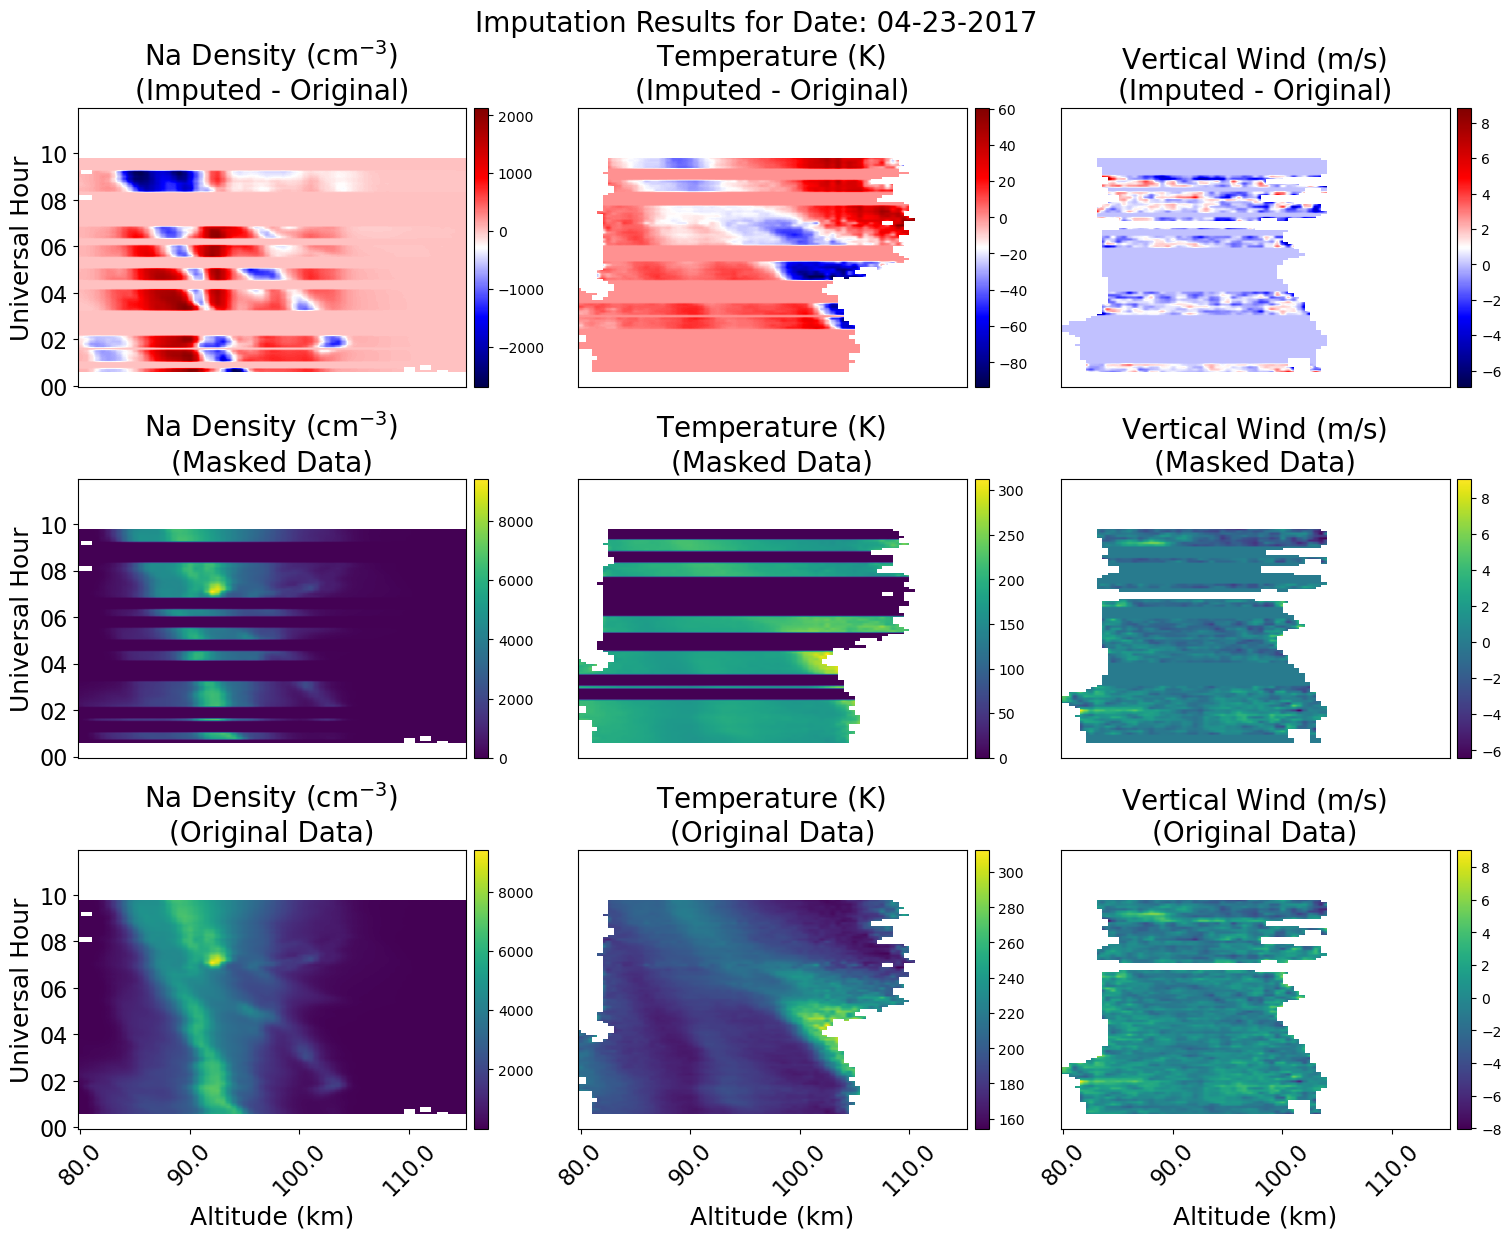

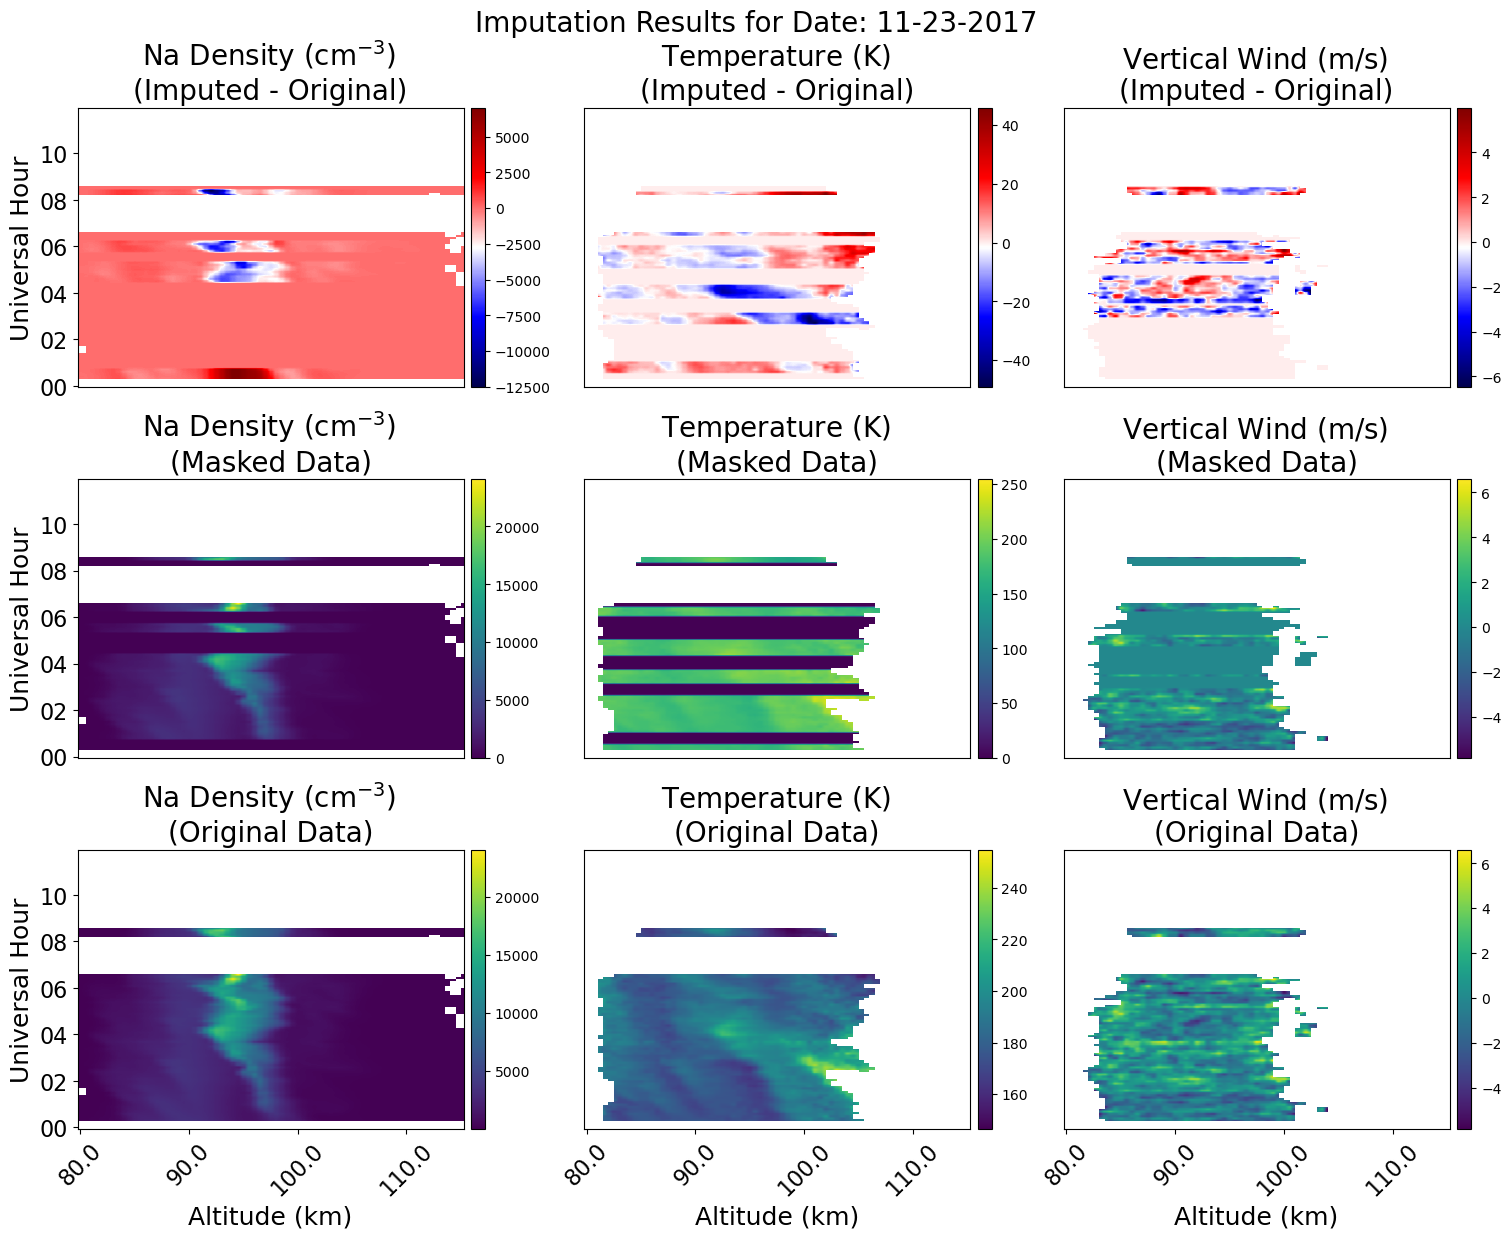

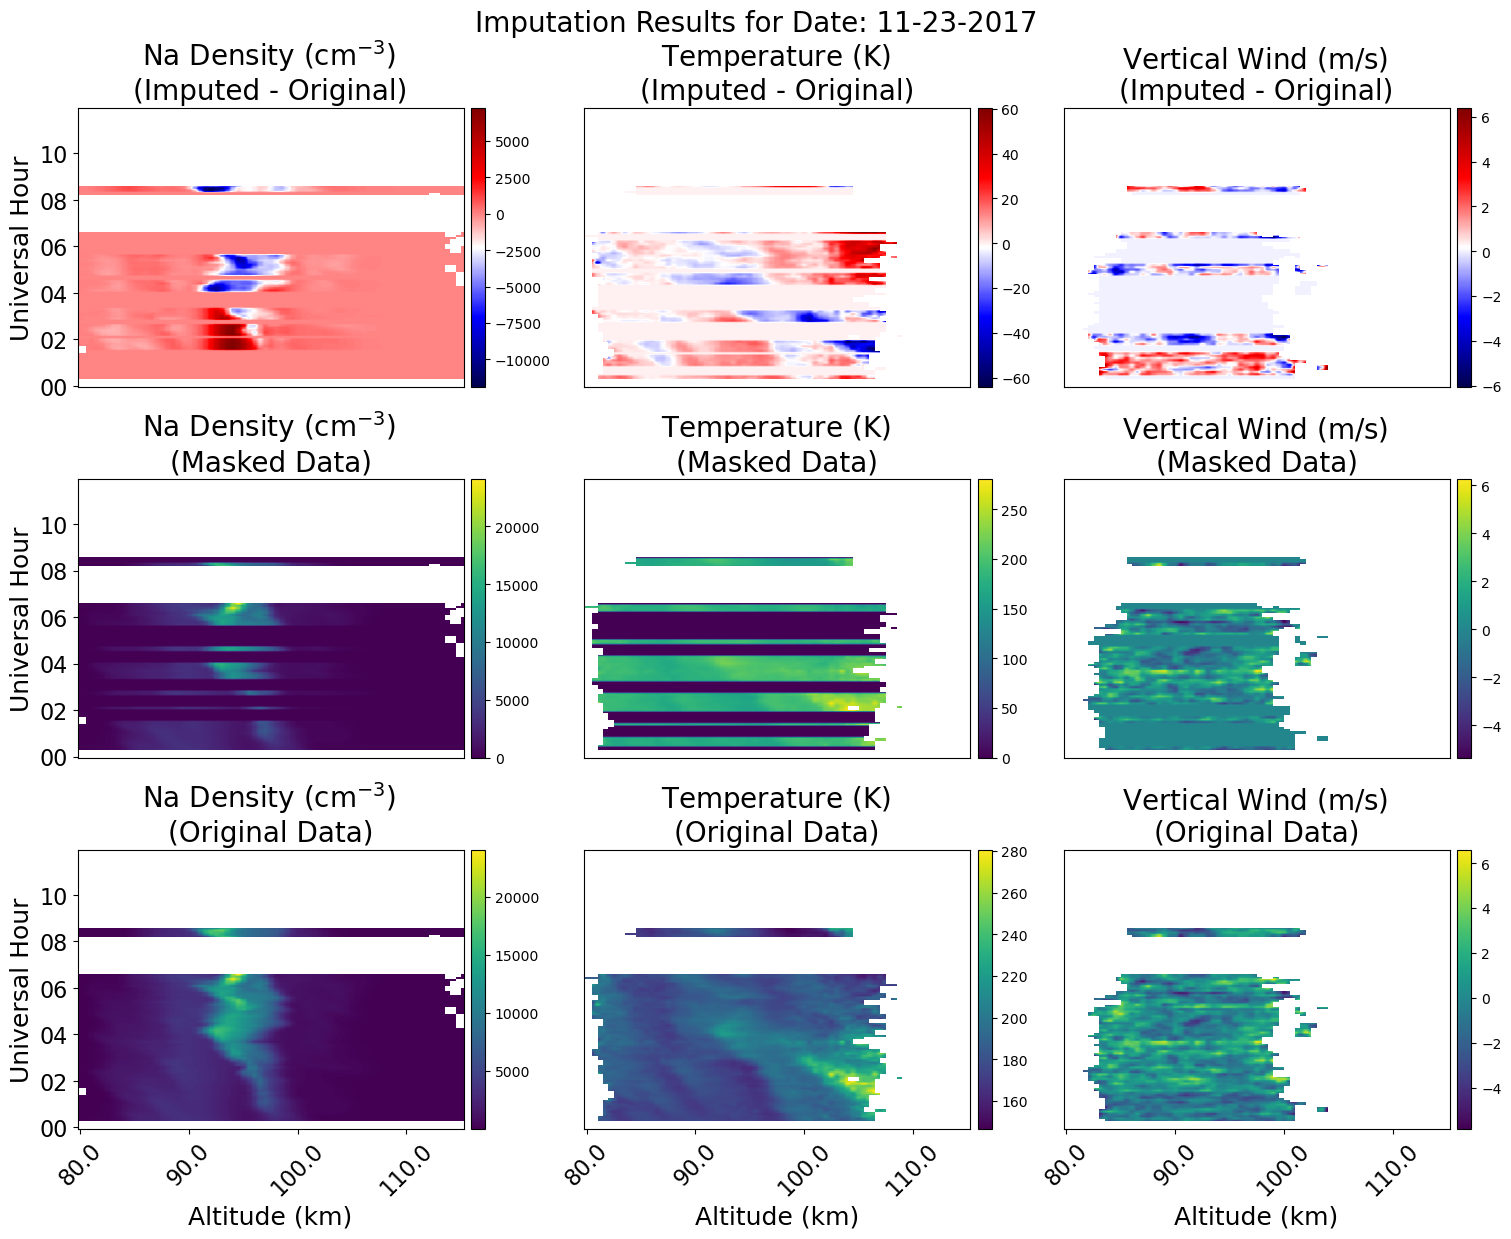

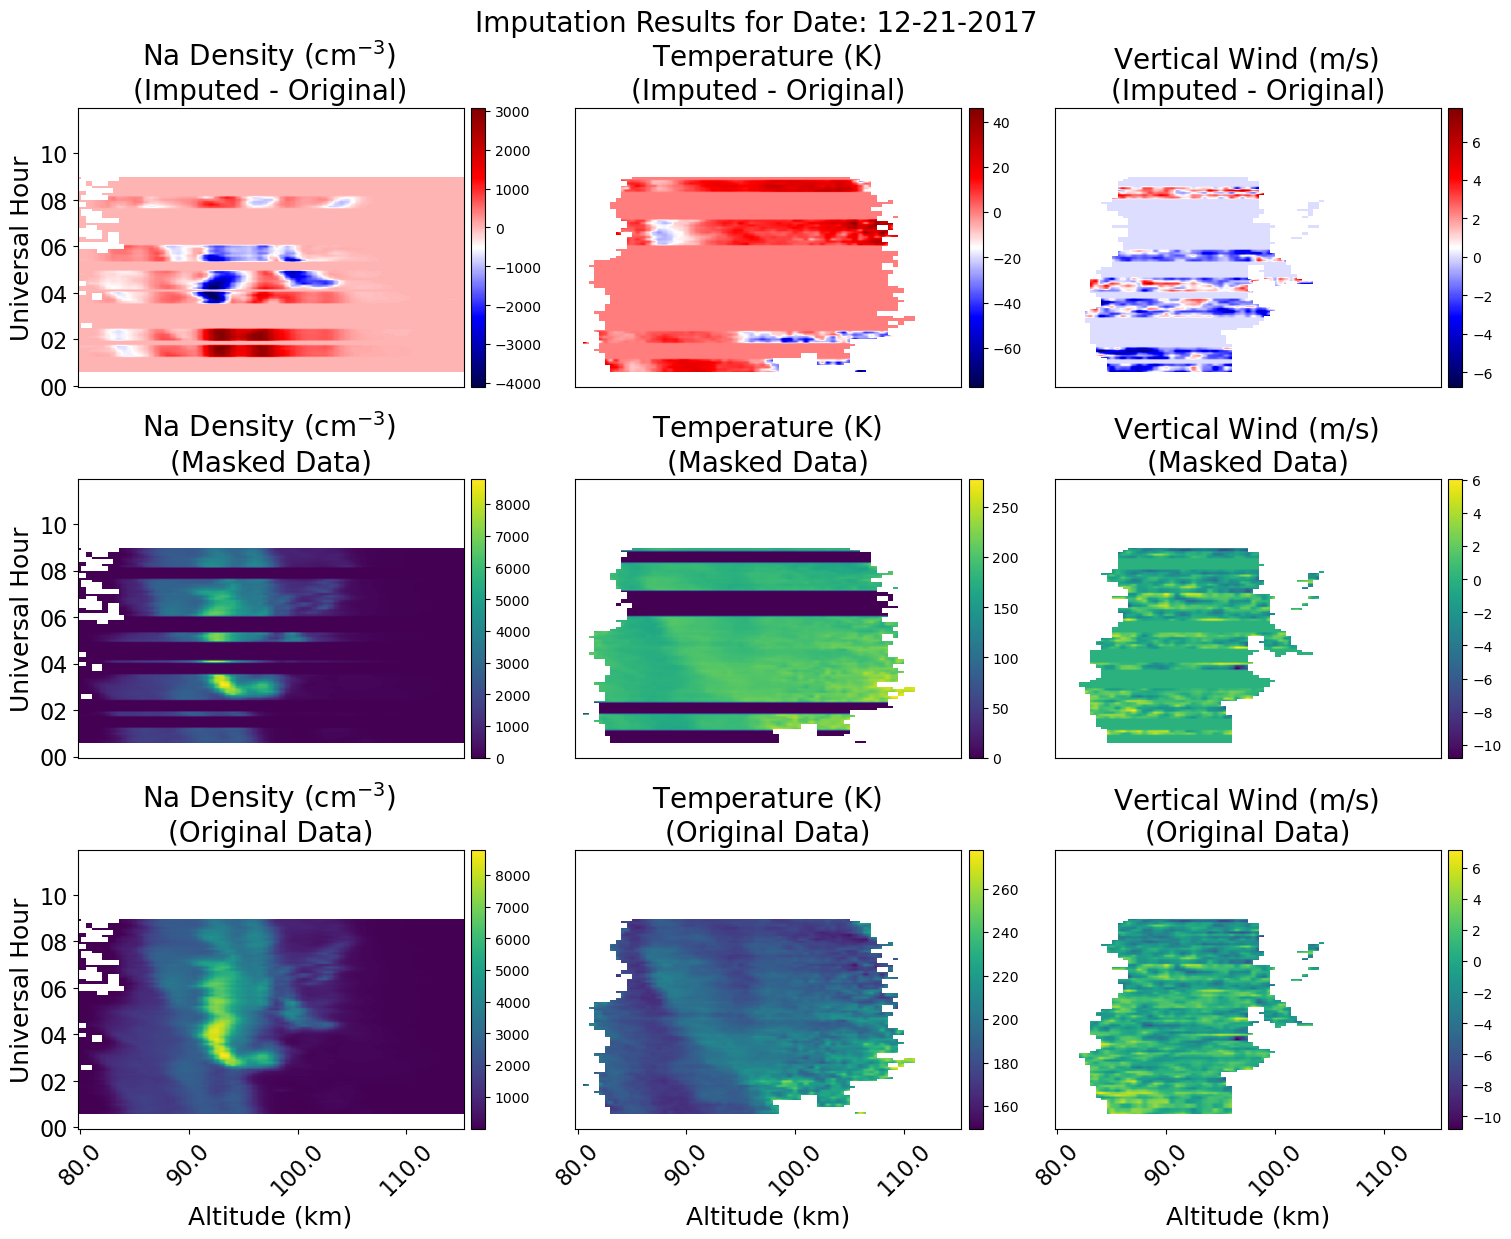

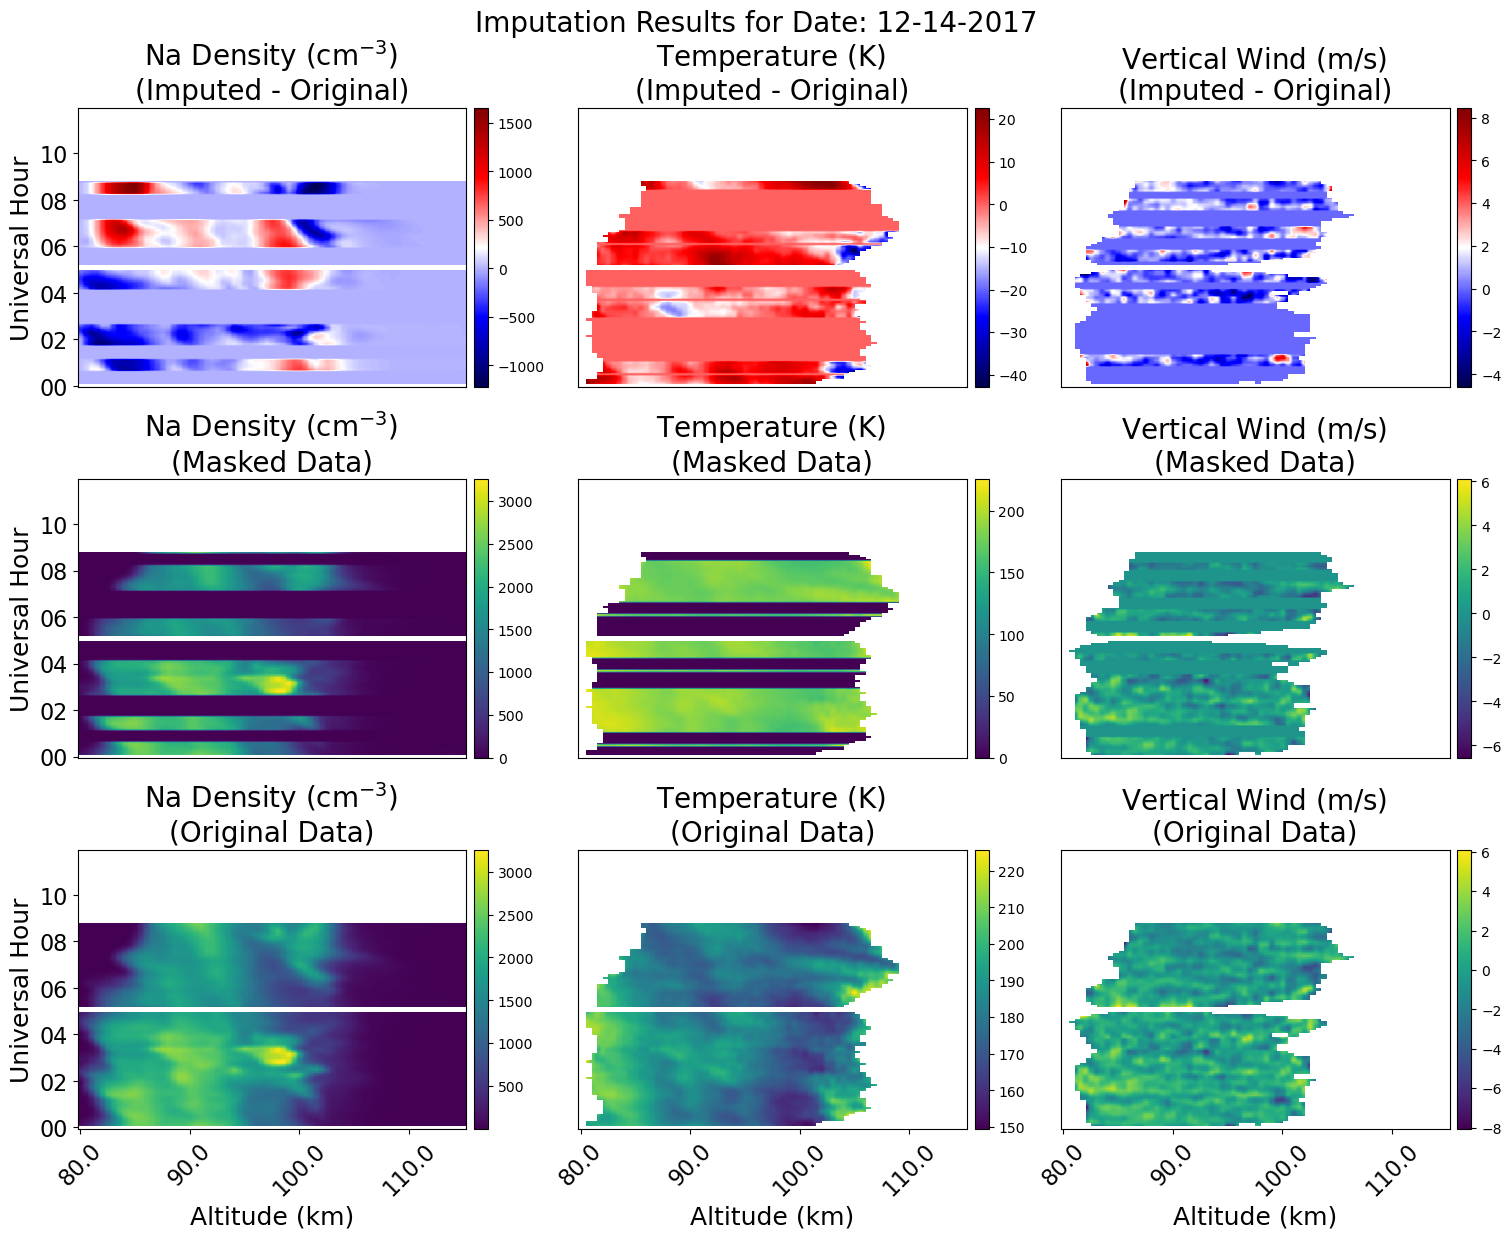

In [4]:
import matplotlib.pyplot as plt
import numpy as np
font_config = {
    "title_fontsize": 20,
    "label_fontsize": 18,
    "tick_label_fontsize": 16
}
def plot_traditional_imputation_results(
    all_original_data_dict, 
    all_mask_dict, 
    all_imputed_data_dict, 
    time_labels, 
    altitude_labels,
    font_config,  # Pass the font configuration dictionary
    time_step=20, 
    altitude_step=20, 
    rotation=45
):
    variables = list(all_imputed_data_dict.keys())
    rows, cols = 3, len(variables)
    num_files = np.array(all_original_data_dict[variables[0]]).shape[0]

    reduced_time_labels = [label.split('_')[1][:2] for label in time_labels[0][::time_step]]
    reduced_time_indices = list(range(0, len(time_labels[0]), time_step))
    reduced_altitude_labels = altitude_labels[::altitude_step]
    reduced_altitude_indices = list(range(0, len(altitude_labels), altitude_step))

    variable_units = {
        "Na Density (cm^(-3))": r"$\text{Na Density (cm}^{-3}\text{)}$",
        "Vertical Wind (m/s)": r"$\text{Vertical Wind (m/s)}$",
        "Temperature (K)": r"$\text{Temperature (K)}$"
    }

    for file_idx in range(num_files):
        fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), constrained_layout=True)

        date_label = time_labels[file_idx][0][:8]
        formatted_date = datetime.strptime(date_label, "%Y%m%d").strftime("%m-%d-%Y")
        fig.suptitle(f"Imputation Results for Date: {formatted_date}", fontsize=font_config["title_fontsize"], y=1.02)
        for row in range(rows):
            for col in range(cols):
                var = variables[col]
                original_data = all_original_data_dict[var][file_idx]
                masked_data = all_mask_dict[var][file_idx]
                imputed_data = all_imputed_data_dict[var][file_idx]
                imputed_diff = imputed_data - original_data

                if row == 0:
                    im = axs[row, col].imshow(imputed_diff, aspect='auto', cmap='seismic', origin='lower')
                    axs[row, col].set_title(f"{variable_units[var]} \n(Imputed - Original)", fontsize=font_config["title_fontsize"])
                elif row == 1:
                    im = axs[row, col].imshow(masked_data * original_data, aspect='auto', cmap='viridis', origin='lower')
                    axs[row, col].set_title(f"{variable_units[var]} \n(Masked Data)", fontsize=font_config["title_fontsize"])
                elif row == 2:
                    im = axs[row, col].imshow(original_data, aspect='auto', cmap='viridis', origin='lower')
                    axs[row, col].set_title(f"{variable_units[var]} \n(Original Data)", fontsize=font_config["title_fontsize"])

                if row == rows - 1:
                    axs[row, col].set_xlabel("Altitude (km)", fontsize=font_config["label_fontsize"])
                    axs[row, col].set_xticks(reduced_altitude_indices)
                    axs[row, col].set_xticklabels(reduced_altitude_labels, fontsize=font_config["tick_label_fontsize"], rotation=rotation)
                else:
                    axs[row, col].set_xticks([])

                if col == 0:
                    axs[row, col].set_ylabel("Universal Hour", fontsize=font_config["label_fontsize"])
                    axs[row, col].set_yticks(reduced_time_indices)
                    axs[row, col].set_yticklabels(reduced_time_labels, fontsize=font_config["tick_label_fontsize"])
                else:
                    axs[row, col].set_yticks([])

                fig.colorbar(im, ax=axs[row, col], orientation='vertical', pad=0.02)
        plt.show()


plot_traditional_imputation_results(
    all_original_data_dict, 
    all_mask_dict, 
    all_imputed_data_dict, 
    time_labels=all_original_data_dict['YYYYMMDD_hhmm'], 
    altitude_labels=alt_lvs,
    font_config = font_config
)

In [15]:
from error_metrics import calculate_metrics
# Call the function and calculate metrics
metrics = calculate_metrics(all_imputed_data_dict, all_original_data_dict, all_mask_dict)
# Display results
for key, metric in metrics.items():
    print(f"Metrics for {key}:")
    for metric_name, value in metric.items():
        print(f"  {metric_name}: {value}")

Metrics for Na Density (cm^(-3)):
  MAE: 451.9691162109375
  MSE: 1054684.5
  RMSE: 1026.9783935546875
  re: 1.7584913969039917
  R^2: 0.7174500572994196
  Mean Imputed: 1383.286865234375
  Std Dev Imputed: 1719.530517578125
Metrics for Temperature (K):
  MAE: 10.245509147644043
  MSE: 208.93516540527344
  RMSE: 14.45458984375
  re: 0.05387486517429352
  R^2: 0.47565721264554983
  Mean Imputed: 187.96783447265625
  Std Dev Imputed: 15.03781509399414
Metrics for Vertical Wind (m/s):
  MAE: 1.6407809257507324
  MSE: 5.0846991539001465
  RMSE: 2.254927635192871
  re: inf
  R^2: 0.09174161476354203
  Mean Imputed: 0.13449165225028992
  Std Dev Imputed: 1.1965187788009644


/Users/huj7/MVI-2D-multivariable/Traditional/error_metrics.py:27: RuntimeWarning: divide by zero encountered in divide
  re = np.mean(np.abs((masked_imputed - masked_original) /masked_original))
